## Import important libraries 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import tensorflow as tf 
%matplotlib inline 

Reading both datasets

In [2]:
credit_df=pd.read_csv('../input/credit-card-approval-prediction/credit_record.csv')
aplication_df=pd.read_csv('../input/credit-card-approval-prediction/application_record.csv')

Invistigate credit_records The dataset

Let's see the historical transactions for each customer

In [3]:
grouped=credit_df.groupby('ID')['STATUS'].value_counts()
grouped

ID       STATUS
5001711  0          3
         X          1
5001712  0         10
         C          9
5001713  X         22
                   ..
5150483  X         18
5150484  0         12
         C          1
5150485  0          2
5150487  C         30
Name: STATUS, Length: 94143, dtype: int64

<AxesSubplot:xlabel='STATUS'>

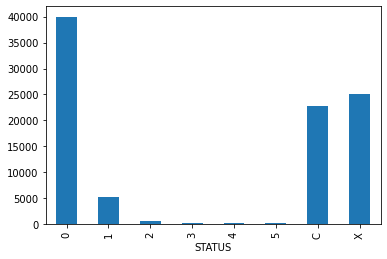

In [4]:
credit_df.groupby('STATUS').count()
number_of_customer_for_each_status=grouped.groupby('STATUS').count()
number_of_customer_for_each_status.plot(kind='bar')


Most customers pay off their loans in 1-29 days<br>
High percetage of customers don't borrow loans <br>
Also High percetage of customers pay off their loan forever <br>
Few people are late in paying off their loans 

In [5]:
credit_grouped=pd.get_dummies(data=credit_df,columns=['STATUS'],
                              prefix='',prefix_sep='').groupby('ID')[sorted(credit_df['STATUS'].unique().tolist())].sum()
credit_grouped=credit_grouped.rename(columns=
                      {'0':'pastdue_1_29',
                       '1':'pastdue_30_59',
                       '2':'pastdue_60_89',
                       '3':'pastdue_90_119',
                       '4':'pastdue_120_149',
                       '5':'pastdue_over_150',
                       'C':'paid_off',
                       'X':'no_loan',
                      })

overall_pastdue=['pastdue_1_29','pastdue_30_59',	'pastdue_60_89',	'pastdue_90_119'	,'pastdue_120_149',	'pastdue_over_150']
credit_grouped['number_of_months']=credit_df.groupby('ID')['MONTHS_BALANCE'].count()
credit_grouped['over_90']=credit_grouped[['pastdue_90_119'	,'pastdue_120_149'	,'pastdue_over_150']].sum(axis=1)
credit_grouped['less_90']=credit_grouped[['pastdue_1_29','pastdue_30_59',	'pastdue_60_89']].sum(axis=1)
credit_grouped['overall_pastdue']=credit_grouped[overall_pastdue].sum(axis=1)
credit_grouped['paid_pastdue_diff']=credit_grouped['paid_off']- credit_grouped['overall_pastdue']
credit_grouped.head()

,pastdue_1_29,pastdue_30_59,pastdue_60_89,pastdue_90_119,pastdue_120_149,pastdue_over_150,paid_off,no_loan,number_of_months,over_90,less_90,overall_pastdue,paid_pastdue_diff
ID,,,,,,,,,,,,,
5001711,3,0,0,0,0,0,0,1,4,0,3,3,-3
5001712,10,0,0,0,0,0,9,0,19,0,10,10,-1
5001713,0,0,0,0,0,0,0,22,22,0,0,0,0
5001714,0,0,0,0,0,0,0,15,15,0,0,0,0
5001715,0,0,0,0,0,0,0,60,60,0,0,0,0


<h1>Let's create strategy to determine Good and Bad Customers</h1>

Good customer conditions :<br>
Check the difference between numbers of times the customer paid off and the number of late and if it is more than threshold then pure good customer else we should take another check <br>
paid_pastdue_diff >=3 or no_loan==number_of_months

also check if he too late or pay off in small period and has a suitable differance <br>
paid_pastdue_diff >=-2 and paid_pastdue_diff < 3  
check and less_90 >= over_90 good <br>

If the customer doesn't achive this conditions then he is a bad customr







In [6]:
target=[]
for index,row in credit_grouped.iterrows() :
  if row['paid_pastdue_diff'] >=3 or (row ['no_loan']==row['number_of_months']) :
    target.append(1)
  elif row['paid_pastdue_diff'] >-2 and row['paid_pastdue_diff'] <3 and (row['less_90'] >=row['over_90']) :
    target.append(1)
  else:
    target.append(0)

credit_grouped['good_or_bad']=target
credit_grouped['good_or_bad'].value_counts()

1    24083
0    21902
Name: good_or_bad, dtype: int64

A good point that we reached to a balanced split

Invistigate aplication_records dataset 

In [7]:
aplication_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


Check duplication

In [8]:
aplication_df.duplicated().sum()

0

<h1>Let's Merge the to datasets to have a full insights <br></h1>
Credit_record dataset don't has only the target ,but aslo has a very interesting historical transactions features that will add benifits

In [9]:
features=['no_loan',	'number_of_months',	'over_90',	'less_90',	'overall_pastdue'	,'paid_pastdue_diff','good_or_bad']
most_important_features=credit_grouped.loc[:,features]
customers_df=pd.merge(aplication_df,most_important_features,on='ID')
customers_df.index=customers_df['ID']
customers_df=customers_df.drop('ID',axis=1)
customers_df

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,...,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,no_loan,number_of_months,over_90,less_90,overall_pastdue,paid_pastdue_diff,good_or_bad
ID,,,,,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,...,0,NaN,2.0,1,16,0,2,2,11,1
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,...,0,NaN,2.0,1,15,0,2,2,10,1
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,...,0,Security staff,2.0,16,30,0,7,7,0,1
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,1,Sales staff,1.0,3,5,0,2,2,-2,0
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,1,Sales staff,1.0,5,5,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,...,0,Managers,2.0,8,12,4,0,4,-4,0
5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,...,1,Medicine staff,2.0,0,24,9,10,19,-14,0
5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,...,1,Medicine staff,2.0,0,33,9,10,19,-5,0


<h1>Split the target and features 

In [10]:
x=customers_df.loc[:,:'paid_pastdue_diff']
y=customers_df['good_or_bad']
x

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,...,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,no_loan,number_of_months,over_90,less_90,overall_pastdue,paid_pastdue_diff
ID,,,,,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,...,0,0,NaN,2.0,1,16,0,2,2,11
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,...,0,0,NaN,2.0,1,15,0,2,2,10
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,...,0,0,Security staff,2.0,16,30,0,7,7,0
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,1,1,Sales staff,1.0,3,5,0,2,2,-2
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,1,1,Sales staff,1.0,5,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,...,0,0,Managers,2.0,8,12,4,0,4,-4
5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,...,1,1,Medicine staff,2.0,0,24,9,10,19,-14
5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,...,1,1,Medicine staff,2.0,0,33,9,10,19,-5


<h1>Train test spilt

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

##Data Visualization

<h3>Invistigates features with the output to determine its effect 

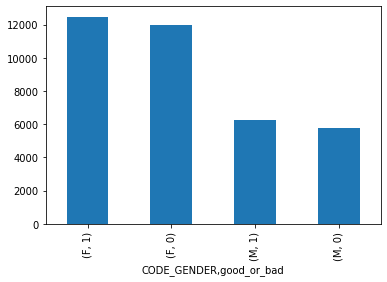

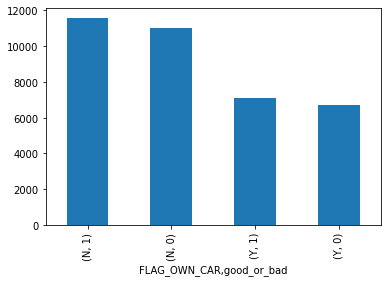

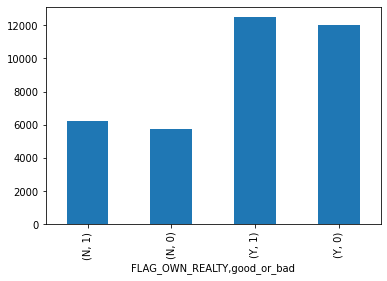

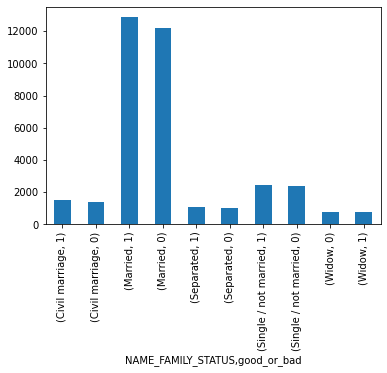

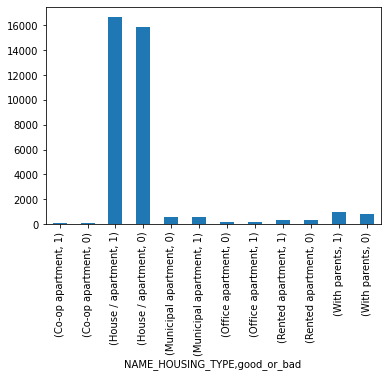

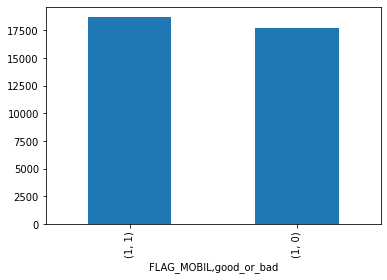

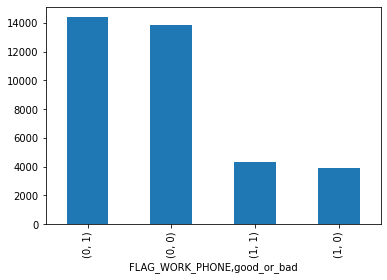

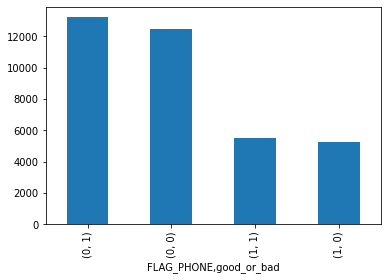

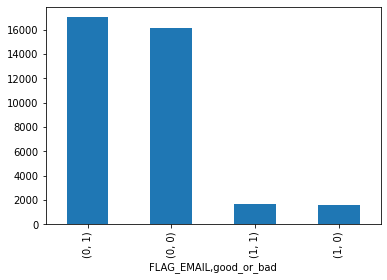

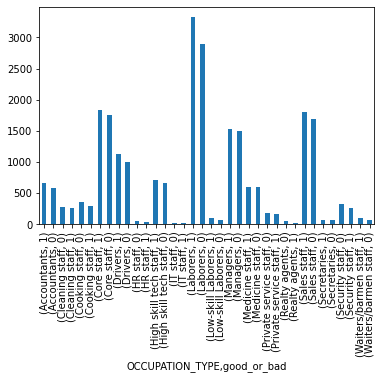

In [12]:
cols=['CODE_GENDER',	'FLAG_OWN_CAR',
            'FLAG_OWN_REALTY','NAME_FAMILY_STATUS',	'NAME_HOUSING_TYPE',
            'FLAG_MOBIL'	,'FLAG_WORK_PHONE',	'FLAG_PHONE',	'FLAG_EMAIL'	,'OCCUPATION_TYPE']
for col in  cols:
  customers_df.groupby(col)['good_or_bad'].value_counts().plot(kind='bar')
  plt.show()

Form the insights above I will drop these features :<br>
1-FLAG_MOBILE because it has one value <br>
2-FLAG_WORK_PHONE ,because it has small effect to determine bad or good <br>
3-FLAG_PHONE ,because it has small effect to determine bad or good<br>
4-FLAG_EMAIL ,because it has small effect to determine bad or good<br>


In [13]:
x_train=x_train.drop(['FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'],axis=1)

## Data preprocessing

In [14]:
# Convert days birth to age column and days employed to work years 
x_train['AGE']=(x_train['DAYS_BIRTH']/365)*-1
x_train['AGE']=x_train['AGE'].apply(lambda v : int(v))
x_train['WORK_YEARS']=x_train['DAYS_EMPLOYED']/365
x_train['WORK_YEARS']=x_train['WORK_YEARS'].apply(lambda v : int(v*-1) if v <0 else 0)
x_train=x_train.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED'])
x_train

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,no_loan,number_of_months,over_90,less_90,overall_pastdue,paid_pastdue_diff,AGE,WORK_YEARS
ID,,,,,,,,,,,,,,,,,,,
5061197,F,N,Y,1,135000.0,Working,Secondary / secondary special,Civil marriage,With parents,Sales staff,3.0,41,46,0,5,5,-5,31,1
5088935,F,N,Y,1,292500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,Private service staff,3.0,1,18,0,17,17,-17,48,24
5142256,F,N,N,0,171000.0,State servant,Secondary / secondary special,Single / not married,House / apartment,Laborers,1.0,14,28,0,14,14,-14,53,4
5061293,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,2.0,0,23,0,8,8,7,63,0
5062023,F,N,Y,0,139500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,NaN,2.0,0,40,0,3,3,34,56,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089700,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,2.0,2,10,0,8,8,-8,63,0
5135839,F,Y,Y,0,90000.0,Pensioner,Higher education,Married,House / apartment,NaN,2.0,0,17,0,3,3,11,58,0
5125595,F,N,N,0,157500.0,Working,Incomplete higher,Separated,House / apartment,NaN,1.0,0,8,0,8,8,-8,31,5


In [15]:
# children count is subset of family size so we can drop the children count feature 
x_train=x_train.drop(columns=['CNT_CHILDREN'])

In [16]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29165 entries, 5061197 to 5022223
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          29165 non-null  object 
 1   FLAG_OWN_CAR         29165 non-null  object 
 2   FLAG_OWN_REALTY      29165 non-null  object 
 3   AMT_INCOME_TOTAL     29165 non-null  float64
 4   NAME_INCOME_TYPE     29165 non-null  object 
 5   NAME_EDUCATION_TYPE  29165 non-null  object 
 6   NAME_FAMILY_STATUS   29165 non-null  object 
 7   NAME_HOUSING_TYPE    29165 non-null  object 
 8   OCCUPATION_TYPE      20094 non-null  object 
 9   CNT_FAM_MEMBERS      29165 non-null  float64
 10  no_loan              29165 non-null  uint8  
 11  number_of_months     29165 non-null  int64  
 12  over_90              29165 non-null  int64  
 13  less_90              29165 non-null  int64  
 14  overall_pastdue      29165 non-null  int64  
 15  paid_pastdue_diff    29165 n

<h1> Dealing with the missing values </h1>
OCCUPATION_TYPE feature has a missing values in it and its a categorical feature so we will fill these values with most frequent value for this column and will use the simple imputer to do this

In [17]:
from sklearn.impute import SimpleImputer 
imputer =SimpleImputer(strategy='most_frequent')
x_imputed=pd.DataFrame(imputer.fit_transform(x_train),index=x_train.index,columns=x_train.columns)
# Imputer change the type of the features so we should reset it again
x_imputed=x_imputed.astype(x_train.dtypes)
#Convert binary types to categorical types to be ready for one hot encoding 
# x_imputed['FLAG_MOBIL']=x_imputed['FLAG_MOBIL'].astype('object')
# x_imputed['FLAG_WORK_PHONE']=x_imputed['FLAG_WORK_PHONE'].astype('object')
# x_imputed['FLAG_PHONE']=x_imputed['FLAG_PHONE'].astype('object')
# x_imputed['FLAG_EMAIL']=x_imputed['FLAG_EMAIL'].astype('object')
# Change no_load type to int64 
x_imputed['no_loan']=x_imputed['no_loan'].astype('int64')
x_imputed['CNT_FAM_MEMBERS']=x_imputed['CNT_FAM_MEMBERS'].astype('int64')
x_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29165 entries, 5061197 to 5022223
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          29165 non-null  object 
 1   FLAG_OWN_CAR         29165 non-null  object 
 2   FLAG_OWN_REALTY      29165 non-null  object 
 3   AMT_INCOME_TOTAL     29165 non-null  float64
 4   NAME_INCOME_TYPE     29165 non-null  object 
 5   NAME_EDUCATION_TYPE  29165 non-null  object 
 6   NAME_FAMILY_STATUS   29165 non-null  object 
 7   NAME_HOUSING_TYPE    29165 non-null  object 
 8   OCCUPATION_TYPE      29165 non-null  object 
 9   CNT_FAM_MEMBERS      29165 non-null  int64  
 10  no_loan              29165 non-null  int64  
 11  number_of_months     29165 non-null  int64  
 12  over_90              29165 non-null  int64  
 13  less_90              29165 non-null  int64  
 14  overall_pastdue      29165 non-null  int64  
 15  paid_pastdue_diff    29165 n

<h1>Dealing with categorical value<br></h1>
Firstly we invistigate them

In [18]:
from pandas.core.algorithms import value_counts
categorical_df=x_imputed.select_dtypes('object')
categorical_df.nunique()

CODE_GENDER             2
FLAG_OWN_CAR            2
FLAG_OWN_REALTY         2
NAME_INCOME_TYPE        5
NAME_EDUCATION_TYPE     5
NAME_FAMILY_STATUS      5
NAME_HOUSING_TYPE       6
OCCUPATION_TYPE        18
dtype: int64

We can notice that only OCCUPATION_TYPE feature has a high cadinality and the rest is low cadinality .<br>
so we will use target encoding for OCCUPATION_TYPE  and one hot encoding for the rest .

In [19]:
# install category_encoders
!pip install category_encoders

In [20]:
from category_encoders import MEstimateEncoder
target_encoder=MEstimateEncoder(m=5,cols=['OCCUPATION_TYPE'])
# train the encoder with the 0.25 of the data to prevent overfitting 
x_encode=x_imputed.sample(frac=0.25)
y_encode=y_train[x_encode.index]
target_encoder.fit(x_encode,y_encode)
# transform the categorical feature
x_encoded=target_encoder.transform(x_imputed)
x_encoded['OCCUPATION_TYPE'].unique()

array([0.52668403, 0.5595489 , 0.50345269, 0.50957984, 0.48786007,
       0.52811742, 0.52427534, 0.44376629, 0.4394694 , 0.47457752,
       0.26312936, 0.50696123, 0.49583962, 0.42929639, 0.50135351,
       0.65085722, 0.44108849, 0.34207803])

In [21]:
x_encoded

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,no_loan,number_of_months,over_90,less_90,overall_pastdue,paid_pastdue_diff,AGE,WORK_YEARS
ID,,,,,,,,,,,,,,,,,,
5061197,F,N,Y,135000.0,Working,Secondary / secondary special,Civil marriage,With parents,0.526684,3,41,46,0,5,5,-5,31,1
5088935,F,N,Y,292500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.559549,3,1,18,0,17,17,-17,48,24
5142256,F,N,N,171000.0,State servant,Secondary / secondary special,Single / not married,House / apartment,0.503453,1,14,28,0,14,14,-14,53,4
5061293,F,N,Y,135000.0,Pensioner,Secondary / secondary special,Married,House / apartment,0.503453,2,0,23,0,8,8,7,63,0
5062023,F,N,Y,139500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0.503453,2,0,40,0,3,3,34,56,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089700,F,N,N,135000.0,Pensioner,Secondary / secondary special,Married,House / apartment,0.503453,2,2,10,0,8,8,-8,63,0
5135839,F,Y,Y,90000.0,Pensioner,Higher education,Married,House / apartment,0.503453,2,0,17,0,3,3,11,58,0
5125595,F,N,N,157500.0,Working,Incomplete higher,Separated,House / apartment,0.503453,1,0,8,0,8,8,-8,31,5


<h1>Standardization</h1>
I have noticed that features are in different ranges so standardization is a very good way to solve this


In [22]:
# Get numiric data
numiric_data=x_encoded._get_numeric_data()
numiric_data

,AMT_INCOME_TOTAL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,no_loan,number_of_months,over_90,less_90,overall_pastdue,paid_pastdue_diff,AGE,WORK_YEARS
ID,,,,,,,,,,,
5061197,135000.0,0.526684,3,41,46,0,5,5,-5,31,1
5088935,292500.0,0.559549,3,1,18,0,17,17,-17,48,24
5142256,171000.0,0.503453,1,14,28,0,14,14,-14,53,4
5061293,135000.0,0.503453,2,0,23,0,8,8,7,63,0
5062023,139500.0,0.503453,2,0,40,0,3,3,34,56,15
...,...,...,...,...,...,...,...,...,...,...,...
5089700,135000.0,0.503453,2,2,10,0,8,8,-8,63,0
5135839,90000.0,0.503453,2,0,17,0,3,3,11,58,0
5125595,157500.0,0.503453,1,0,8,0,8,8,-8,31,5


In [23]:
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()
numiric_data_scaled=scaler.fit_transform(numiric_data)
numiric_data_scaled=pd.DataFrame(numiric_data_scaled,index=numiric_data.index,columns=numiric_data.columns)
numiric_data_scaled

,AMT_INCOME_TOTAL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,no_loan,number_of_months,over_90,less_90,overall_pastdue,paid_pastdue_diff,AGE,WORK_YEARS
ID,,,,,,,,,,,
5061197,-0.508109,0.805625,0.879838,4.280718,1.649149,-0.056822,-0.407433,-0.410694,-0.366559,-1.063600,-0.720373
5088935,1.042301,2.066258,0.879838,-0.346481,-0.224007,-0.056822,1.096527,1.079200,-1.133201,0.412959,2.859398
5142256,-0.153730,-0.085484,-1.314959,1.157359,0.444977,-0.056822,0.720537,0.706727,-0.941541,0.847241,-0.253446
5061293,-0.508109,-0.085484,-0.217561,-0.462161,0.110485,-0.056822,-0.031443,-0.038220,0.400083,1.715805,-0.876015
5062023,-0.463812,-0.085484,-0.217561,-0.462161,1.247758,-0.056822,-0.658093,-0.659009,2.125028,1.107810,1.458618
...,...,...,...,...,...,...,...,...,...,...,...
5089700,-0.508109,-0.085484,-0.217561,-0.230801,-0.759194,-0.056822,-0.031443,-0.038220,-0.558220,1.715805,-0.876015
5135839,-0.951084,-0.085484,-0.217561,-0.462161,-0.290905,-0.056822,-0.658093,-0.659009,0.655630,1.281523,-0.876015
5125595,-0.286622,-0.085484,-1.314959,-0.462161,-0.892991,-0.056822,-0.031443,-0.038220,-0.558220,-1.063600,-0.097804


In [24]:
x_encoded[numiric_data_scaled.columns]=numiric_data_scaled[numiric_data_scaled.columns]
x_standarized=x_encoded.copy()

<h1>Dealing with the low cadinality categorical features</h1>
the best way is to use one hot encoding

In [25]:
x_train=pd.get_dummies(x_standarized)
x_train

,AMT_INCOME_TOTAL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,no_loan,number_of_months,over_90,less_90,overall_pastdue,paid_pastdue_diff,AGE,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
ID,,,,,,,,,,,,,,,,,,,,,
5061197,-0.508109,0.805625,0.879838,4.280718,1.649149,-0.056822,-0.407433,-0.410694,-0.366559,-1.063600,...,0,0,0,0,0,0,0,0,0,1
5088935,1.042301,2.066258,0.879838,-0.346481,-0.224007,-0.056822,1.096527,1.079200,-1.133201,0.412959,...,0,0,0,0,0,1,0,0,0,0
5142256,-0.153730,-0.085484,-1.314959,1.157359,0.444977,-0.056822,0.720537,0.706727,-0.941541,0.847241,...,0,0,1,0,0,1,0,0,0,0
5061293,-0.508109,-0.085484,-0.217561,-0.462161,0.110485,-0.056822,-0.031443,-0.038220,0.400083,1.715805,...,1,0,0,0,0,1,0,0,0,0
5062023,-0.463812,-0.085484,-0.217561,-0.462161,1.247758,-0.056822,-0.658093,-0.659009,2.125028,1.107810,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089700,-0.508109,-0.085484,-0.217561,-0.230801,-0.759194,-0.056822,-0.031443,-0.038220,-0.558220,1.715805,...,1,0,0,0,0,1,0,0,0,0
5135839,-0.951084,-0.085484,-0.217561,-0.462161,-0.290905,-0.056822,-0.658093,-0.659009,0.655630,1.281523,...,1,0,0,0,0,1,0,0,0,0
5125595,-0.286622,-0.085484,-1.314959,-0.462161,-0.892991,-0.056822,-0.031443,-0.038220,-0.558220,-1.063600,...,0,1,0,0,0,1,0,0,0,0


In [26]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29165 entries, 5061197 to 5022223
Data columns (total 38 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   AMT_INCOME_TOTAL                                   29165 non-null  float64
 1   OCCUPATION_TYPE                                    29165 non-null  float64
 2   CNT_FAM_MEMBERS                                    29165 non-null  float64
 3   no_loan                                            29165 non-null  float64
 4   number_of_months                                   29165 non-null  float64
 5   over_90                                            29165 non-null  float64
 6   less_90                                            29165 non-null  float64
 7   overall_pastdue                                    29165 non-null  float64
 8   paid_pastdue_diff                                  29165 non-null  float64
 9 

## Prepare test dateset

In [27]:
x_test=x_test.drop(['FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'],axis=1)
# Convert days birth to age column and days employed to work years 
x_test['AGE']=(x_test['DAYS_BIRTH']/365)*-1
x_test['AGE']=x_test['AGE'].apply(lambda v : int(v))
x_test['WORK_YEARS']=x_test['DAYS_EMPLOYED']/365
x_test['WORK_YEARS']=x_test['WORK_YEARS'].apply(lambda v : int(v*-1) if v <0 else 0)
x_test=x_test.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED'])
# children count is subset of family size so we can drop the children count feature 
x_test=x_test.drop(columns=['CNT_CHILDREN'])

# We use the imputer from simple imputer that fitted from the train data
x_test_imputed=pd.DataFrame(imputer.transform(x_test),index=x_test.index,columns=x_test.columns)
# imputer change the type of the features so we should reset it again
x_test_imputed=x_test_imputed.astype(x_test.dtypes)
x_test_imputed['no_loan']=x_test_imputed['no_loan'].astype('int64')
x_test_imputed['CNT_FAM_MEMBERS']=x_test_imputed['CNT_FAM_MEMBERS'].astype('int64')

# We use the target_encoder from categiry encoders that fitted from the train data
x_test_encoded=target_encoder.transform(x_test_imputed)
# Standarization 
numiric_test_data=x_test_encoded._get_numeric_data()
numiric_test_data_scaled=scaler.transform(numiric_test_data)
numiric_test_data_scaled=pd.DataFrame(numiric_test_data_scaled,index=numiric_test_data.index,columns=numiric_test_data.columns)
x_test_encoded[numiric_test_data_scaled.columns]=numiric_test_data_scaled[numiric_test_data_scaled.columns]
x_test_standarized=x_test_encoded.copy()
# one hot encoded
x_test=pd.get_dummies(x_test_standarized)
x_test

,AMT_INCOME_TOTAL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,no_loan,number_of_months,over_90,less_90,overall_pastdue,paid_pastdue_diff,AGE,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
ID,,,,,,,,,,,,,,,,,,,,,
5149577,-0.508109,-0.683587,-0.217561,-0.462161,-0.491601,-0.056822,-0.282103,-0.286536,0.080649,0.239246,...,1,0,0,0,0,1,0,0,0,0
5023523,-0.065135,-0.085484,-0.217561,-0.346481,0.511876,-0.056822,-0.282103,-0.286536,0.975065,-0.108180,...,1,0,0,0,0,1,0,0,0,0
5042272,-0.286622,-0.085484,-0.217561,-0.346481,-0.892991,-0.056822,-0.156773,-0.162378,-0.494333,1.889518,...,1,0,0,0,0,1,0,0,0,0
5091181,-1.172571,-0.683587,-0.217561,0.000559,-1.093687,-0.056822,-0.908753,-0.907325,-0.111012,-1.150457,...,0,1,0,0,0,1,0,0,0,0
5135854,-0.065135,-0.085484,0.879838,-0.462161,-1.294382,-0.056822,-1.034083,-1.031483,0.080649,0.065533,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5148815,-0.729596,-0.085484,-0.217561,-0.346481,1.782946,-0.056822,-0.282103,-0.286536,2.188915,1.542092,...,1,0,0,0,0,1,0,0,0,0
5054426,-0.729596,0.860607,-0.217561,0.694639,-0.759194,-0.056822,-1.034083,-1.031483,-0.047125,-0.976744,...,1,0,0,0,0,1,0,0,0,0
5092356,-0.641001,-0.085484,-0.217561,0.694639,0.712571,-0.056822,-1.034083,-1.031483,1.358386,1.368380,...,0,0,0,0,0,1,0,0,0,0


## Machine learning models

Support vector machine

In [28]:
from sklearn import svm
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
model=svm.NuSVC()
# x,x_valid,y,y_valid=train_test_split(x_train,y_train,test_size=0.2)
model.fit(x_train,y_train)
# Calculate train accuracy 
y_train_pred=model.predict(x_train)
print(f'Train accuracy score = {accuracy_score(y_train,y_train_pred)}')
print(f'Train f1_score = {f1_score(y_train,y_train_pred)}')
print(f'Train roc_auc_score = {roc_auc_score(y_train,y_train_pred)}')
# Calculate test accuracy
y_test_pred=model.predict(x_test)
print(f'test accuracy score = {accuracy_score(y_test,y_test_pred)}')
print(f'test f1_score = {f1_score(y_test,y_test_pred)}')
print(f'test roc_auc_score = {roc_auc_score(y_test,y_test_pred)}')

Train accuracy score = 0.9301217212412138
Train f1_score = 0.9284611064307778
Train roc_auc_score = 0.9311622932730748
test accuracy score = 0.9267690619857378
test f1_score = 0.9258539294640378
test roc_auc_score = 0.9286352025681371


Linear support vector machine

In [29]:
from sklearn import svm
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
model=svm.LinearSVC()
# x,x_valid,y,y_valid=train_test_split(x_train,y_train,test_size=0.2)
model.fit(x_train,y_train)
# Calculate train accuracy 
y_train_pred=model.predict(x_train)
print(f'Train accuracy score = {accuracy_score(y_train,y_train_pred)}')
print(f'Train f1_score = {f1_score(y_train,y_train_pred)}')
print(f'Train roc_auc_score = {roc_auc_score(y_train,y_train_pred)}')
# Calculate test accuracy
y_test_pred=model.predict(x_test)
print(f'test accuracy score = {accuracy_score(y_test,y_test_pred)}')
print(f'test f1_score = {f1_score(y_test,y_test_pred)}')
print(f'test roc_auc_score = {roc_auc_score(y_test,y_test_pred)}')

Train accuracy score = 0.9999657123264186
Train f1_score = 0.9999664913044934
Train roc_auc_score = 0.999964897500702
test accuracy score = 1.0
test f1_score = 1.0
test roc_auc_score = 1.0


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Random Forest for classification

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

model=RandomForestClassifier(n_estimators=100,criterion='gini',random_state=1,max_leaf_nodes=8)
# x,x_valid,y,y_valid=train_test_split(x_train,y_train,test_size=0.2)
model.fit(x_train,y_train)
# Calculate train accuracy 
y_train_pred=model.predict(x_train)
print(f'Train accuracy score = {accuracy_score(y_train,y_train_pred)}')
print(f'Train f1_score = {f1_score(y_train,y_train_pred)}')
print(f'Train roc_auc_score = {roc_auc_score(y_train,y_train_pred)}')
# Calculate test accuracy
y_test_pred=model.predict(x_test)
print(f'test accuracy score = {accuracy_score(y_test,y_test_pred)}')
print(f'test f1_score = {f1_score(y_test,y_test_pred)}')
print(f'test roc_auc_score = {roc_auc_score(y_test,y_test_pred)}')

Train accuracy score = 0.9999657123264186
Train f1_score = 0.9999664913044934
Train roc_auc_score = 0.999964897500702
test accuracy score = 1.0
test f1_score = 1.0
test roc_auc_score = 1.0


XGBoost Clasifier

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

model=XGBClassifier(n_estimators=50,learning_rate=0.01,random_state=0)
# x,x_valid,y,y_valid=train_test_split(x_train,y_train,test_size=0.2)
model.fit(x_train,y_train)
# Calculate train accuracy 
y_train_pred=model.predict(x_train)
print(f'Train accuracy score = {accuracy_score(y_train,y_train_pred)}')
print(f'Train f1_score = {f1_score(y_train,y_train_pred)}')
print(f'Train roc_auc_score = {roc_auc_score(y_train,y_train_pred)}')
# Calculate test accuracy
y_test_pred=model.predict(x_test)
print(f'test accuracy score = {accuracy_score(y_test,y_test_pred)}')
print(f'test f1_score = {f1_score(y_test,y_test_pred)}')
print(f'test roc_auc_score = {roc_auc_score(y_test,y_test_pred)}')

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:38:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy score = 0.9999657123264186
Train f1_score = 0.9999664913044934
Train roc_auc_score = 0.999964897500702
test accuracy score = 1.0
test f1_score = 1.0
test roc_auc_score = 1.0
